# README

This code compares the lambda value that is selected by GCV and the lambda that is considered the oracle value.

# Import Packages

In [1]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import os
import pandas as pd

# Options

In [2]:
n_elements = 128
#Weighting term to ensure the c_i and T2_i are roughly the same magnitude
ob_weight = 100
n_noise_realizations = 100 #500

num_multistarts = 10

pCombo_oi = [0.2,0.8,50,70]

target_SNR = 20

agg_weights = np.array([1, 1, 1/ob_weight, 1/ob_weight])

tdata = np.linspace(0, 635, n_elements)
lambdas = np.append(0, np.logspace(-7,1,51))

upper_bound = [2,2,100,300] #Set upper bound on parameters c1, c2, T21, T22, respectively
lower_bound = [0,0,0,0]

np.random.seed(6)

# Define Parameters

### Small Helper Functions

In [3]:
########################### Simple Functions ##############################
# Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def estimate_parameters(data, lam, n_initials = num_multistarts):
    #Pick n_initials random initial conditions within the bound, and choose the one giving the lowest model-data mismatch residual
    random_residuals = np.empty(n_initials)
    estimates = np.zeros((n_initials,4))
    # data_start = np.abs(data[0])
    data_tilde = np.append(data, [0,0,0,0]) # Adds zeros to the end of the regularization array for the param estimation
    
    for i in range(n_initials):
        np.random.seed(i)
        ic1 = np.random.uniform(0,1)
        ic2 = 1-ic1
        ic1 = ic1#*data_start
        ic2 = ic2#*data_start
        iT21 = np.random.uniform(1,upper_bound[-2])
        iT22 = np.random.uniform(iT21,upper_bound[-1])
        p0 = [ic1,ic2,iT21,iT22]
        # up_bnd = upper_bound*np.array([data_start, data_start, 1, 1])
        # assert(np.size(up_bnd) == np.size(p0))
        
        try:
            popt, _, info_popt, _, _ = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (lower_bound, upper_bound), p0=p0, max_nfev = 4000, full_output = True)
        except:
            popt = [0,0,1,1]
            print("Max feval reached")
        
        estimates[i,:] = check_param_order(popt)#Require T22>T21

        random_residuals[i] = np.sum(info_popt['fvec']**2)
    min_residual_idx = np.argmin(random_residuals)
    min_residual_estimates = estimates[min_residual_idx,:]
 
    return min_residual_estimates

def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data


def generate_all_estimates(param_combo, noise_iters, SNR_oi):
    #Generates a comprehensive matrix of all parameter estimates for all param combinations, 
    #noise realizations, SNR values, and lambdas of interest
    param_estimates = np.zeros((noise_iters, len(lambdas), len(param_combo)))
    RSS_estimates = np.zeros((noise_iters, len(lambdas)))

    underlying = G(tdata, *param_combo)

    for nr in trange(noise_iters):    #Loop through all noise realizations
        noise_data = add_noise(underlying, SNR_oi)

        for iLam in range(len(lambdas)):    #Loop through all lambda values
            lam = lambdas[iLam]
            iter_estimates = estimate_parameters(noise_data, lam)

            estimated_model = G(tdata, *iter_estimates)
            one_rss = np.sum((estimated_model - noise_data)**2)
            param_estimates[nr,iLam,:] = iter_estimates
            RSS_estimates[nr,iLam] = one_rss

    return param_estimates, RSS_estimates

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,4))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

def to_readable(file):
    df = pd.read_feather(file)
    ALL_ESTIMATES = np.stack(df["Estimates"].values) #shape: (index, noise_realization, lambda, popt)
    ALL_RES = np.stack(df["RSS"].values) #shape: (index, noise_realization, lambda, residual)
    ALL_PARAMS = np.stack(df["TrueParams"].values) #(index, 4)
    return ALL_PARAMS, ALL_ESTIMATES, ALL_RES

In [4]:
def get_GCV_value(params, RSS, lamb):

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    GCVjacobian = J(tdata, *params)
    if (lamb < 1e-7):
        GCVdenominator = len(tdata) - np.linalg.matrix_rank(GCVjacobian)
    else:
        C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(lamb**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
        (n,n) = C_GCV.shape
        identity = np.identity(n)
        GCVdenominator = (identity - C_GCV).trace()
    GCV = RSS/(GCVdenominator**2)
    return GCV


# Generate Data Sets

# Case Specific Results

In [5]:
spec_estimates, spec_RSS = generate_all_estimates(pCombo_oi, n_noise_realizations, target_SNR)

100%|██████████| 100/100 [13:34<00:00,  8.14s/it]


In [6]:
spec_estimates.shape

(100, 52, 4)

### Traditional Oracle - Across Noise Realizations

In [7]:
spec_bias = np.mean(spec_estimates - pCombo_oi, axis = 0)
spec_var = np.var(spec_estimates, axis = 0)

spec_MSE = spec_bias**2 + spec_var

avgOrc_min_lambda = lambdas[np.argmin(spec_MSE, axis = 0)]
print(avgOrc_min_lambda)

[3.31131121e+00 1.00000000e-07 1.09647820e+00 3.01995172e-03]


### Noise Realization Specific GCV Results

In [8]:
spec_GCV_lambdas = np.zeros(spec_estimates.shape[0])
spec_GCV_curves = np.zeros((spec_estimates.shape[0], len(lambdas)))
count_singular = 0

for nr in range(spec_estimates.shape[0]):
    for iLam in range(len(lambdas)):
        temp_RSS = spec_RSS[nr,iLam]

        try:
            spec_GCV_curves[nr, iLam] = get_GCV_value(spec_estimates[nr,iLam,:], temp_RSS, lambdas[iLam])
        except:
            spec_GCV_curves[nr, iLam] = np.inf
            count_singular += 1

    spec_GCV_lambdas[nr] = lambdas[np.argmin(spec_GCV_curves[nr,:])]

print(f'There were {count_singular} singular GCV arrays')
print(f'The range of GCV lambdas is min = {np.min(spec_GCV_lambdas) :.2e} to max = {np.max(spec_GCV_lambdas):.2e}')
print(f'The average GCV lambda value is {np.mean(spec_GCV_lambdas):.2e}')
print(f'GCV value range at lambda = 0: min = {np.min(spec_GCV_curves[:,0]):.2e}, ax = {np.max(spec_GCV_curves[:,0]):.2e}, mean = {np.mean(spec_GCV_curves[:,0]):.2e}')

There were 0 singular GCV arrays
The range of GCV lambdas is min = 8.32e-02 to max = 1.20e-01
The average GCV lambda value is 8.35e-02
GCV value range at lambda = 0: min = 1.93e-05, ax = 2.30e-05, mean = 2.29e-05


### Noise Realization Specific Oracle Values

In [9]:
spec_orc_lambdas = np.zeros(spec_estimates.shape[0])
spec_orc_curves = np.zeros((spec_estimates.shape[0], len(lambdas)))

for nr in range(spec_estimates.shape[0]):
    for iLam in range(len(lambdas)):
        
        weights = [1, 1, 0.01, 0.01]
        spec_orc_curves[nr,iLam] = np.sum((weights*(spec_estimates[nr,iLam,:] - pCombo_oi))**2)

    spec_orc_lambdas[nr] = lambdas[np.argmin(spec_orc_curves[nr,:])]

print(f'The range of oracle lambdas is min = {np.min(spec_orc_lambdas)} to max = {np.max(spec_orc_lambdas)}')
print(f'The average oracle lambda value is {np.mean(spec_orc_lambdas)}')

The range of oracle lambdas is min = 0.00010964781961431851 to max = 0.5248074602497723
The average oracle lambda value is 0.005356625943915898


# Plotting Curves

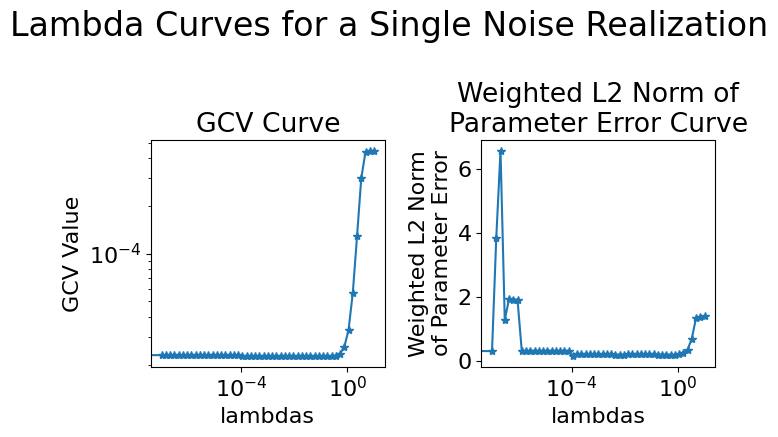

In [10]:
noise_realization = 10

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,2, figsize=(7,4.5), tight_layout=True)
plt.rc('font', size = 20)
fig.suptitle(f"Lambda Curves for a Single Noise Realization")
plt.rc('font', size = 16)
ax[0].set_title('GCV Curve')
ax[0].set_xlabel('lambdas')
ax[0].set_ylabel('GCV Value')
ax[0].loglog(lambdas, spec_GCV_curves[noise_realization,:], marker = '*')

ax[1].set_title('Weighted L2 Norm of\nParameter Error Curve')
ax[1].set_xlabel('lambdas')
ax[1].set_ylabel('Weighted L2 Norm\nof Parameter Error')
ax[1].semilogx(lambdas, spec_orc_curves[noise_realization,:], marker = '*')

plt.show()

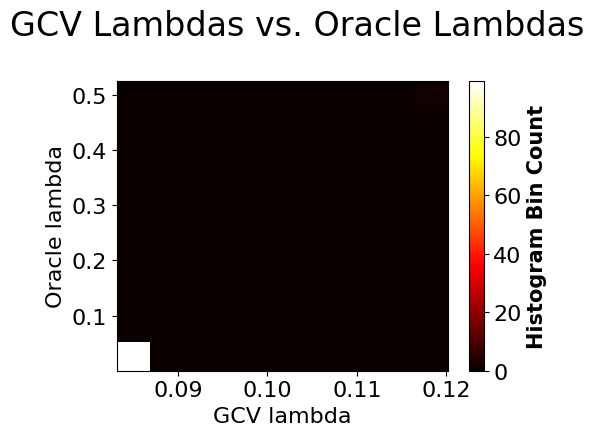

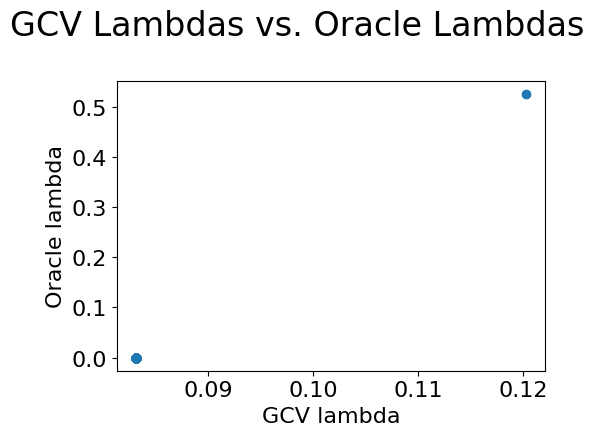

In [11]:

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize=(5.5,4.5), tight_layout=True)
plt.rc('font', size = 20)
fig.suptitle(f"GCV Lambdas vs. Oracle Lambdas")
plt.rc('font', size = 16)
data = ax.hist2d(spec_GCV_lambdas, spec_orc_lambdas, cmap = plt.get_cmap('hot', 128))
ax.set_xlabel('GCV lambda')
ax.set_ylabel('Oracle lambda')
cbar = fig.colorbar(data[3])
cbar.set_label(label=f'Histogram Bin Count',size=15, weight='bold')

plt.show()

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize=(5.5,4.5), tight_layout=True)
plt.rc('font', size = 20)
fig.suptitle(f"GCV Lambdas vs. Oracle Lambdas")
plt.rc('font', size = 16)
ax.scatter(spec_GCV_lambdas, spec_orc_lambdas)#, ls = '', marker = 'o')
ax.set_xlabel('GCV lambda')
ax.set_ylabel('Oracle lambda')


plt.show()

In [12]:
cov_result = np.cov(spec_GCV_lambdas, spec_orc_lambdas)
corr = scipy.stats.pearsonr(spec_GCV_lambdas, spec_orc_lambdas)

print(f"Pearson's Correlation Coefficient = {corr}")

Pearson's Correlation Coefficient = PearsonRResult(statistic=0.9999999999999991, pvalue=0.0)
